## Importing the libraries

In [21]:
# For data manipulation and analysis
import pandas as pd
import numpy as np
import seaborn as sns
import plotly
import os
import matplotlib.pyplot as plt

# For serialization purpose
import pickle

# For interactive visualizations
import plotly.graph_objects as go
import plotly.subplots as ps
import plotly.express as px

# For scaling the features
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# For doing multivariate imputation
from sklearn.impute import KNNImputer

# For performing diemsionality reduction
from sklearn.manifold import TSNE

# For visualization of clusters and scatter plot in 3d
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# For doing clustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.cluster import OPTICS
import matplotlib.colors as mcolors
import colorsys
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

# Set option to opt-in to future behavior
pd.set_option('future.no_silent_downcasting', True)

## Reading the data from csv files

In [2]:
# Reading the dataframes
df = pd.DataFrame()

# Loading the traing and test data
train_data = pd.read_csv('../datasets/train.csv') 
test_data = pd.read_csv('../datasets/test.csv')

In [3]:
# Dropping the features
train_data.drop(['Segmentation','ID','Var_1'],axis=1,inplace=True)
test_data.drop(['ID','Var_1'],axis=1,inplace=True)

In [4]:
df = pd.concat([df,train_data,test_data],axis=0)
print(f"The data have {(df.shape)[0]} rows and {(df.shape)[1]} columns")

The data have 10695 rows and 8 columns


## Exploratory data analysis

In [5]:
# Checking 5 random rows 
df.sample(5)

Gender Ever_Married  Age Graduated Profession  Work_Experience  \
3930  Female           No   46       Yes   Engineer              1.0   
7751    Male          Yes   28        No  Executive              0.0   
4783  Female          Yes   51       Yes     Doctor              1.0   
5671    Male           No   20        No        NaN              2.0   
3754    Male          Yes   47       Yes     Artist              NaN   

     Spending_Score  Family_Size  
3930            Low          1.0  
7751           High          4.0  
4783        Average          4.0  
5671            Low          2.0  
3754        Average          2.0

In [6]:
duplicate_cnts = df.duplicated().sum()
if duplicate_cnts > 0:
    df.drop_duplicates(inplace=True)
    print(f"{duplicate_cnts} dupicate values removed")
else:
    print("There are no duplicate values")

2019 dupicate values removed


In [7]:
df.isnull().mean()*100

Gender              0.000000
Ever_Married        2.132319
Age                 0.000000
Graduated           1.129553
Profession          1.821116
Work_Experience    11.088059
Spending_Score      0.000000
Family_Size         4.956201
dtype: float64

In [8]:
cols_nan = ['Ever_Married','Graduated','Profession','Family_Size']
for cols in cols_nan:
    df[cols] = df[cols].fillna(df[cols].mode()[0])

In [9]:
# Checking percentage of missing values
df.isnull().mean()*100

Gender              0.000000
Ever_Married        0.000000
Age                 0.000000
Graduated           0.000000
Profession          0.000000
Work_Experience    11.088059
Spending_Score      0.000000
Family_Size         0.000000
dtype: float64

In [10]:
df.head(4)

Gender Ever_Married  Age Graduated  Profession  Work_Experience  \
0    Male           No   22        No  Healthcare              1.0   
1  Female          Yes   38       Yes    Engineer              NaN   
2  Female          Yes   67       Yes    Engineer              1.0   
3    Male          Yes   67       Yes      Lawyer              0.0   

  Spending_Score  Family_Size  
0            Low          4.0  
1        Average          3.0  
2            Low          1.0  
3           High          2.0

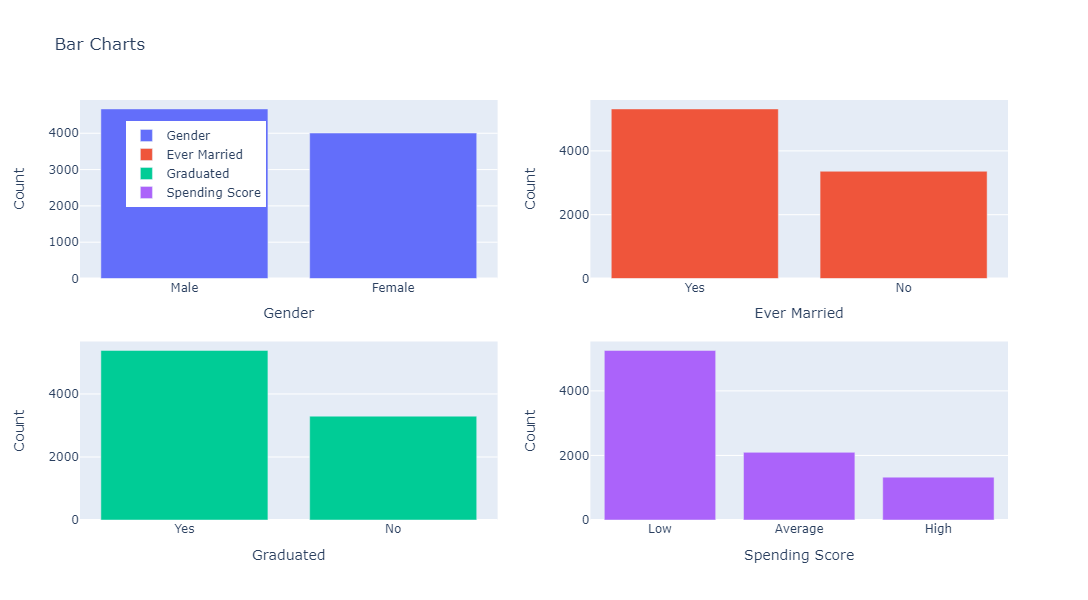

In [15]:
# Create subplot grid
fig = ps.make_subplots(rows=2, cols=2)

# Plotting barplots
fig.add_trace(
    go.Bar(x=df['Gender'].value_counts().index, y=df['Gender'].value_counts().values, name='Gender'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=df['Ever_Married'].value_counts().index, y=df['Ever_Married'].value_counts().values, name='Ever Married'),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=df['Graduated'].value_counts().index, y=df['Graduated'].value_counts().values, name='Graduated'),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x=df['Spending_Score'].value_counts().index, y=df['Spending_Score'].value_counts().values, name='Spending Score'),
    row=2, col=2
)

# Update layout for elegance
fig.update_layout(
    title='Bar Charts',
    height=600,
    width=800,
    showlegend=True,
    legend=dict(x=0.05, y=0.95)
)

# Update axes labels
fig.update_xaxes(title_text='Gender', row=1, col=1)
fig.update_yaxes(title_text='Count', row=1, col=1)

fig.update_xaxes(title_text='Ever Married', row=1, col=2)
fig.update_yaxes(title_text='Count', row=1, col=2)

fig.update_xaxes(title_text='Graduated', row=2, col=1)
fig.update_yaxes(title_text='Count', row=2, col=1)

fig.update_xaxes(title_text='Spending Score', row=2, col=2)
fig.update_yaxes(title_text='Count', row=2, col=2)

# Show the plot
fig.show()

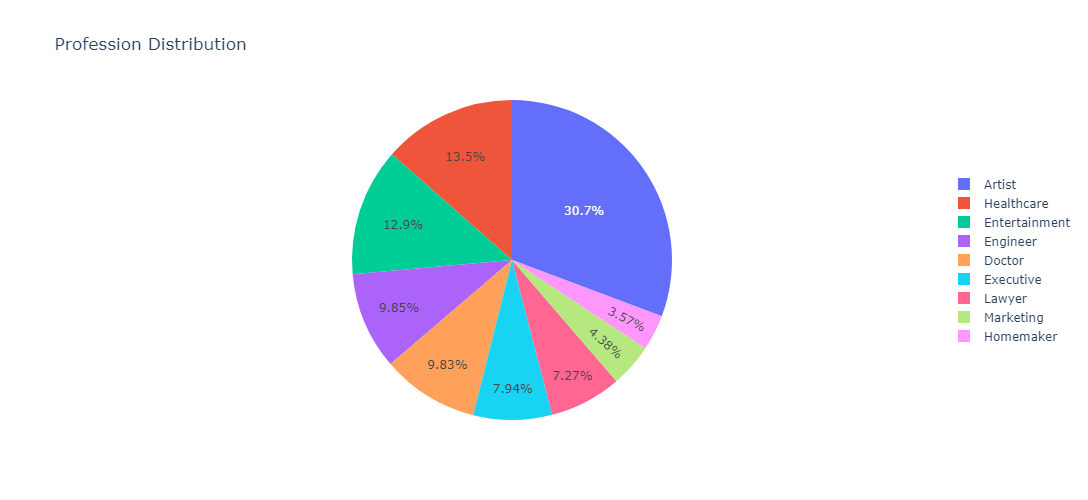

In [19]:
fig = px.pie(df, names='Profession', title='Profession Distribution')

# Update layout for elegance
fig.update_layout(
    height=500,
    width=700,
    showlegend=True,
    legend=dict(x=1, y=0.5)
)

# Show the plot
fig.show()

In [22]:
# Ordinal encoding
df['Spending_Score'] = df['Spending_Score'].replace({'Low': 0.0, 'Average': 1.0, 'High': 2.0}).infer_objects(copy=False)

In [23]:
features_to_encode = ['Gender', 'Ever_Married','Graduated','Profession']

# Applying get_dummies to the specified features
encoded_df = pd.get_dummies(df, columns=features_to_encode,dtype=int,drop_first=True)

## Multivariate imputation

In [26]:
# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Perform KNN imputation
new_df = pd.DataFrame(imputer.fit_transform(encoded_df), columns=encoded_df.columns)

## Dimensionality reduction
Benefits of Dimensionality Reduction Before Clustering:

- Addresses the Curse of Dimensionality: In high dimensions, distance measures like Euclidean distance become less meaningful, leading to inaccurate clustering results. Dimensionality reduction helps mitigate this by focusing on the most relevant features.
- Improves Clustering Performance: By reducing redundant or irrelevant dimensions, clustering algorithms can identify tighter clusters and achieve better separation between them. This can lead to more accurate and interpretable results.
- Reduces Computational Cost: Clustering algorithms can be computationally expensive, especially on high-dimensional data. Dimensionality reduction reduces the number of features to be processed, leading to faster execution times.

In [38]:
# Exrtracting the raw values to be used for doing dimensionality reduction
raw_vals = new_df.values

In [42]:
# Dimensionality reduction using TSNE
tsne = TSNE(n_components=3)

reduced_data = tsne.fit_transform(raw_vals)

In [33]:
# Save the array as a pickle file
with open('../artifacts/reduce_data.pkl', 'wb') as f:
    pickle.dump(reduced_data, f)

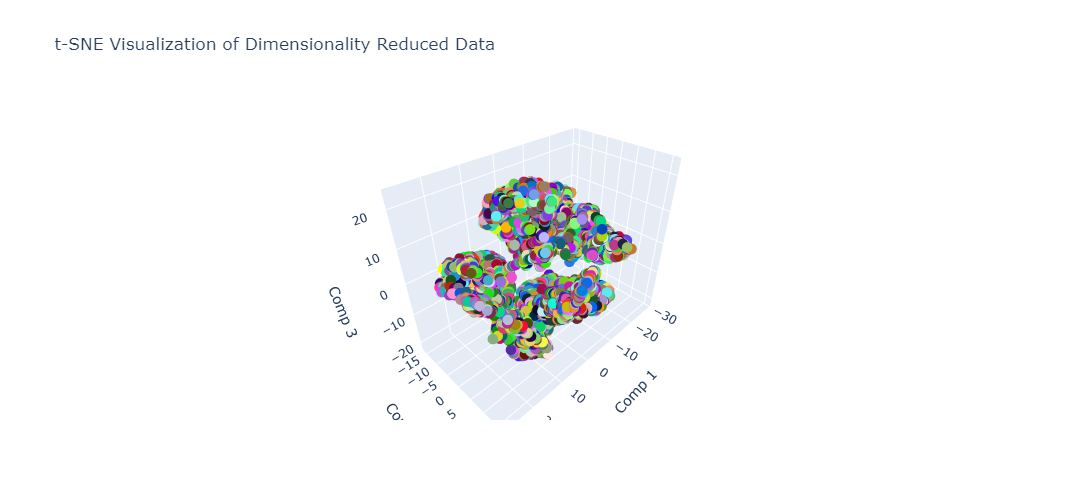

In [35]:
# Define colors for better visualization (replace with your own logic)
colors = np.random.rand(len(reduced_data), 3) 

# Create a 3D scatter plot using Plotly
fig = make_subplots(specs=[[{"type": "scatter3d"}]])

tsne_trace = go.Scatter3d(
    x=reduced_data[:, 0],
    y=reduced_data[:, 1],
    z=reduced_data[:, 2],
    mode='markers',
    marker=dict(size=6, color=colors),
    name='t-SNE'
)

fig.add_trace(tsne_trace)

# Set plot title and axis labels
fig.update_layout(
    title='t-SNE Visualization of Dimensionality reduced Data',
    scene=dict(
        xaxis_title='Comp 1',
        yaxis_title='Comp 2',
        zaxis_title='Comp 3'
    ),
    height=500
)

# Render the plot
fig.show()

In [58]:
new_df.head(5)

Age  Work_Experience  Spending_Score  Family_Size  Gender_Male  \
0  22.0              1.0             0.0          4.0          1.0   
1  38.0              5.4             1.0          3.0          0.0   
2  67.0              1.0             0.0          1.0          0.0   
3  67.0              0.0             2.0          2.0          1.0   
4  40.0              3.8             2.0          6.0          0.0   

   Ever_Married_Yes  Graduated_Yes  Profession_Doctor  Profession_Engineer  \
0               0.0            0.0                0.0                  0.0   
1               1.0            1.0                0.0                  1.0   
2               1.0            1.0                0.0                  1.0   
3               1.0            1.0                0.0                  0.0   
4               1.0            1.0                0.0                  0.0   

   Profession_Entertainment  Profession_Executive  Profession_Healthcare  \
0                       0.0                   0.0                    1.0   
1                       0.0                   0.0                    0.0   
2                       0.0                   0.0                    0.0   
3                       0.0                   0.0                    0.0   
4                       1.0                   0.0                    0.0   

   Profession_Homemaker  Profession_Lawyer  Profession_Marketing  
0                   0.0                0.0                   0.0  
1                   0.0                0.0                   0.0  
2                   0.0                0.0                   0.0  
3                   0.0                1.0                   0.0  
4                   0.0                0.0                   0.0

- Age
- Work experience
- Spending score
- Family size

## Scaling the features
Here's a general guideline on which scaling method could be beneficial for each type of clustering algorithm:

- **Partition-based clustering** (e.g., K-means, K-medoids):Beneficial scaling: Standardization (Z-score normalization) is often beneficial for partition-based clustering algorithms. This is because these algorithms use distance measures (e.g., Euclidean distance) to determine cluster assignments. Standardization scales the features to have a mean of 0 and a standard deviation of 1, ensuring that all features contribute equally to the distance computation.
- **Density-based clustering** (e.g., DBSCAN): Beneficial scaling: While density-based clustering algorithms like DBSCAN are less sensitive to scaling compared to partition-based methods, it's generally recommended to scale the data to a similar range. Min-max scaling (scaling features to a fixed range, typically [0, 1]) can be useful in this case. However, if the density metric is based on Euclidean distance, standardization can also be beneficial.
- **Hierarchical clustering** (e.g., Agglomerative clustering): Beneficial scaling: Hierarchical clustering does not necessarily require scaling since it operates on the pairwise distances between data points. However, if the distance metric used (e.g., Euclidean distance) is sensitive to differences in scale, standardization can be beneficial. Otherwise, no scaling or minimal scaling might be needed.

In [73]:
# Instantiating the scaling classes
scaling = StandardScaler()
min_max = MinMaxScaler()

ss_data = min_max.fit_transform(reduced_data)
minmax_data = scaling.fit_transform(reduced_data)

## Partition Based clustering (K-MEANS)
For doing partition based clustering it is important to first provide the value of k as hyper-parameter. So let's first find the value of k using elbow and sillhoute method.

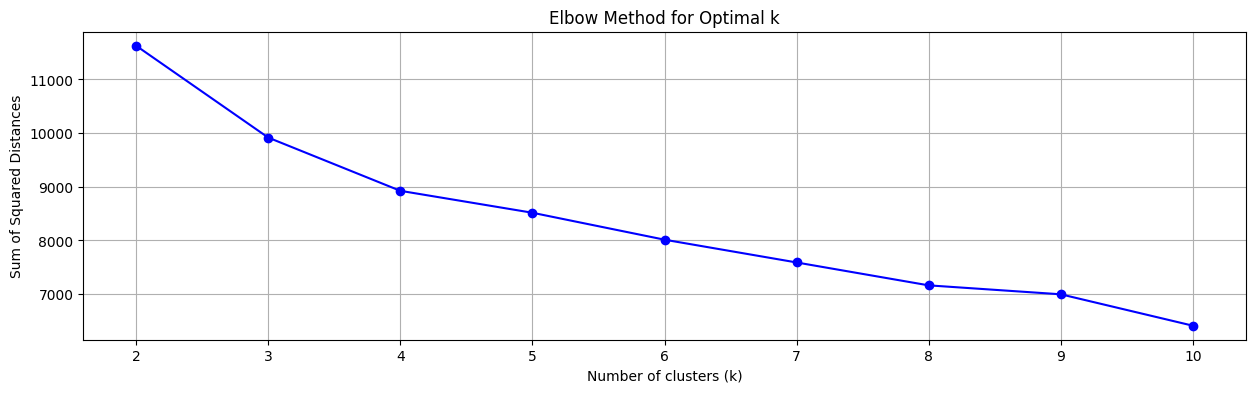

In [69]:
# Calculate sum of squared distances for different values of k
sse = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(ss_data)
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(15, 4))
plt.plot(range(2, 11), sse, marker='o', linestyle='-', color='b')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

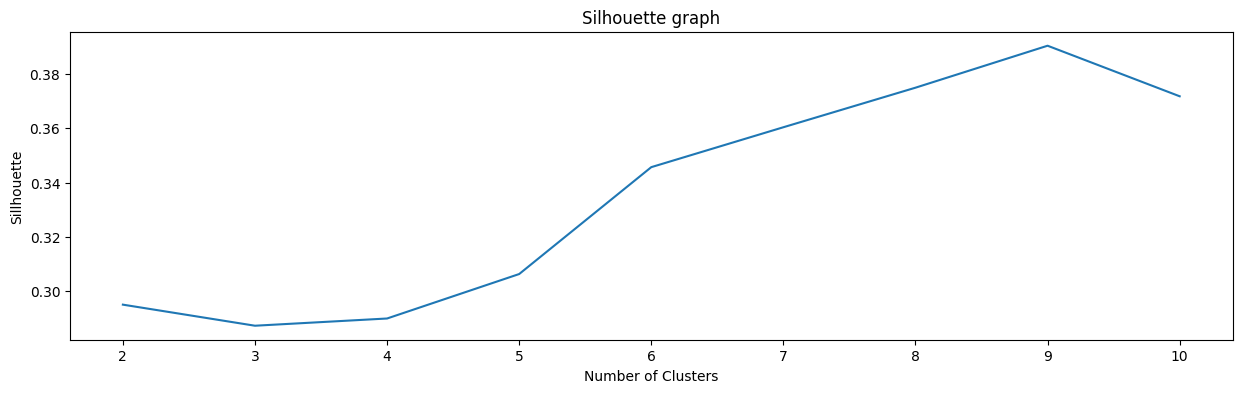

In [46]:
# Empty list to score silhouette score
silhouette_sc = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    cluster_labels = kmeans.fit_predict(ss_data)
    silhouette_avg = silhouette_score(ss_data, cluster_labels)
    silhouette_sc.append(silhouette_avg)

fig,ax = plt.subplots(figsize=(15,4))

plt.plot(range(2, 11), silhouette_sc)
plt.title('Silhouette graph')
plt.xlabel('Number of Clusters')
plt.ylabel('Sillhouette')
plt.show()

In [55]:
kmeans = KMeans(n_clusters = 9)

# Fitting the data and getting the clusters
clusters_kmeans = kmeans.fit_predict(ss_data)

# Get unique cluster labels (excluding noise)
unique_labels_kmeans = set(clusters_kmeans)

In [49]:
# Let's define a function to generate the pastel colors
def generate_pastel_colors(num_colors):
    pastel_colors = []
    for i in range(num_colors):

        # Equally spaced hues
        hue = (i * 1.61803398875) / num_colors  # Using the golden ratio for better distribution

        # Higher saturation for more vibrant colors
        saturation = 0.8

        # Lightness to create pastel effect
        lightness = 0.65  # Adjusted lightness for a wider range of colors
        rgb = colorsys.hls_to_rgb(hue, lightness, saturation)
        pastel_colors.append('#{:02x}{:02x}{:02x}'.format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255)))
        
    return pastel_colors

In [56]:
def plot_clusters_3d(data, clusters, unique_labels, algo):
    """
    Plots clusters in a 3D scatter plot.

    Parameters:
    reduced_data (numpy.ndarray): The reduced data (e.g., obtained from PCA).
    clusters (numpy.ndarray): Cluster assignments for each data point.
    unique_labels (numpy.ndarray): Unique cluster labels.
    algo (str): Name of the clustering algorithm.

    Returns:
    None
    """
    def generate_pastel_colors(num_colors):
        """Generates pastel colors."""
        colors = []
        for i in range(num_colors):
            hue = (i * 137.508) % 360
            colors.append(tuple([int(j * 255) for j in colorsys.hsv_to_rgb(hue / 360, 0.6, 0.9)]))
        return colors

    # Determine the number of unique clusters
    num_colors = len(unique_labels)
    
    # Generate pastel colors for clusters
    cluster_colors = generate_pastel_colors(num_colors)
    
    # Create a 3D scatter plot using Plotly
    fig = make_subplots(specs=[[{"type": "scatter3d"}]])

    # Plot each cluster separately
    for cluster_id in unique_labels:
        cluster_indices = np.where(clusters == cluster_id)[0]
        cluster_data = data[cluster_indices]

        # Using modulo to repeat colors
        cluster_color = cluster_colors[cluster_id % len(cluster_colors)]
        cluster_trace = go.Scatter3d(
            x=cluster_data[:, 0],
            y=cluster_data[:, 1],
            z=cluster_data[:, 2],
            mode='markers',
            marker=dict(size=6, color='rgb'+str(cluster_color)),  # Assigning specific color to each data point
            name=f'Cluster {cluster_id}'
        )
        fig.add_trace(cluster_trace)

    # Set plot title and axis labels
    fig.update_layout(
        title=f'3D Scatter Plot with {algo} Clusters',
        scene=dict(
            xaxis_title='Comp 1',
            yaxis_title='Comp 2',
            zaxis_title='Comp 3'
        ),
        height=500
    )

    # Render the plot
    fig.show()

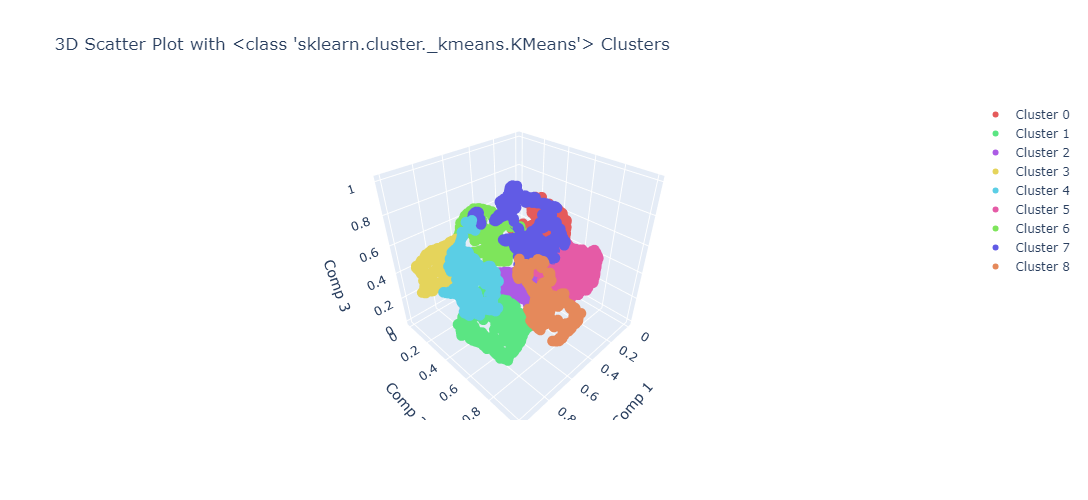

In [75]:
# Plotting cluster
plot_clusters_3d(ss_data,clusters_kmeans,unique_labels_kmeans,KMeans)

## Density based clustering (DBSCAN)
https://www.kaggle.com/code/monikanoorkarima/customer-segmentation

In [79]:
# Define DBSCAN parameters
eps = 0.5
min_samples = 5

# Create a DBSCAN object
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# Fit the data to DBSCAN
clusters_dbscan = dbscan.fit_predict(minmax_data)

# Get unique cluster labels (excluding noise)
unique_labels_dbscan = set(clusters_dbscan)

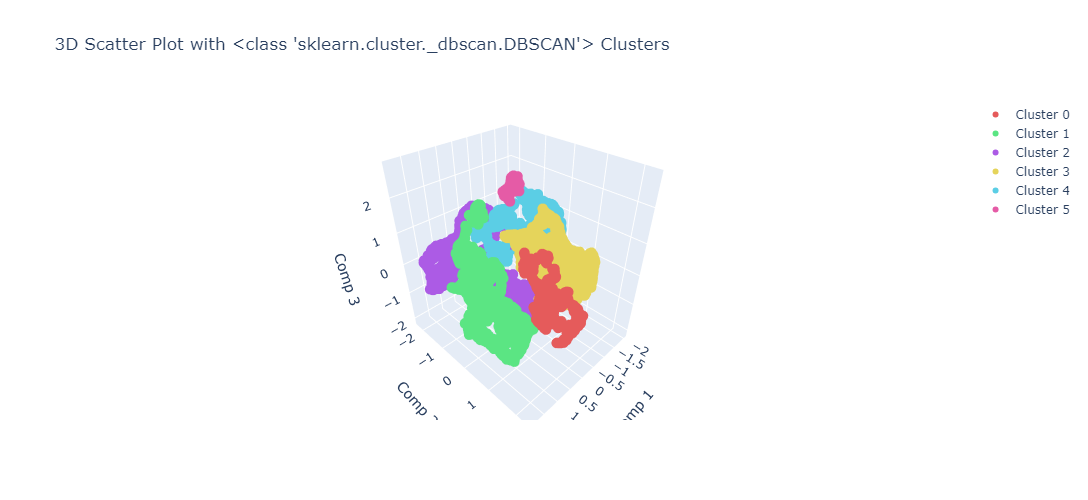

In [83]:
# Plotting cluster
plot_clusters_3d(minmax_data,clusters_dbscan,unique_labels_dbscan,DBSCAN)

## Hierarchical clustering (AGNES)

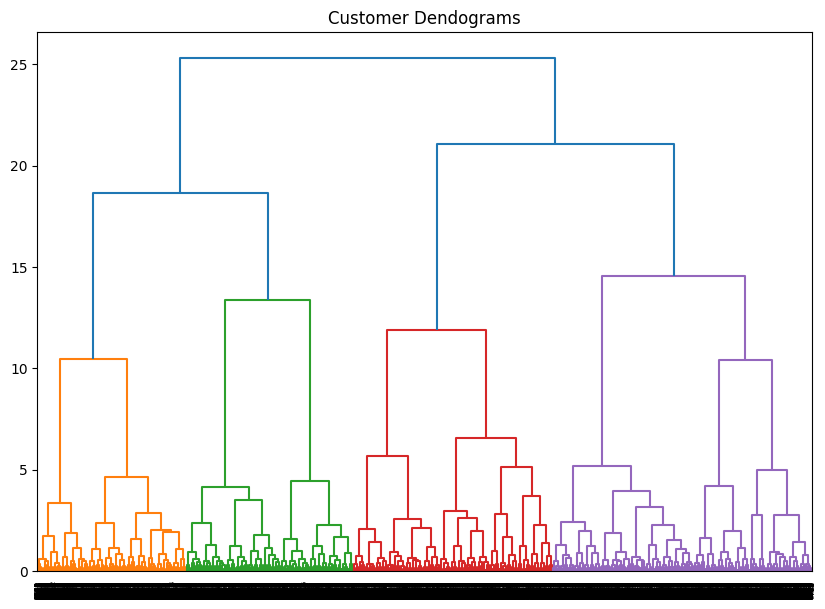

In [84]:
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(ss_data, method='ward'))

In [86]:
agnes = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
clusters_agnes = agnes.fit_predict(ss_data)

# Getting unique labels
unique_labels_agnes = set(clusters_agnes)

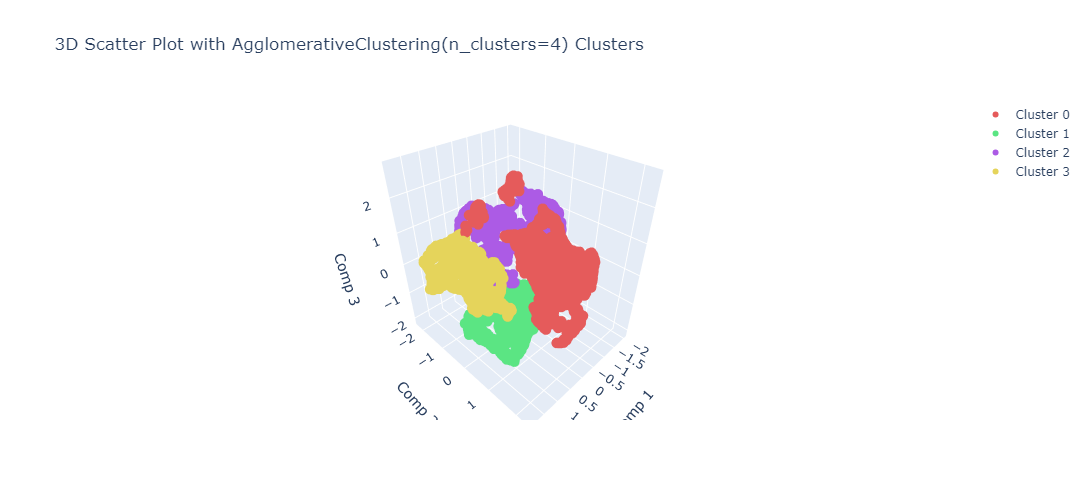

In [90]:
# Plotting cluster
plot_clusters_3d(minmax_data,clusters_agnes,unique_labels_agnes,agnes)

## Performance analysis of clustering algorithms
We will analyze the clusters quality using the sillhouette score by using reduced_data, standard_scaled_data and Min_Max_scaled data

In [92]:
def calculate_silhouette_score(data,clusters):
    return silhouette_score(data,clusters)

In [93]:
kmeans_ss = calculate_silhouette_score(ss_data,clusters_kmeans)
dbscan_ss = calculate_silhouette_score(minmax_data,clusters_dbscan)
agnes_ss = calculate_silhouette_score(ss_data,clusters_agnes)

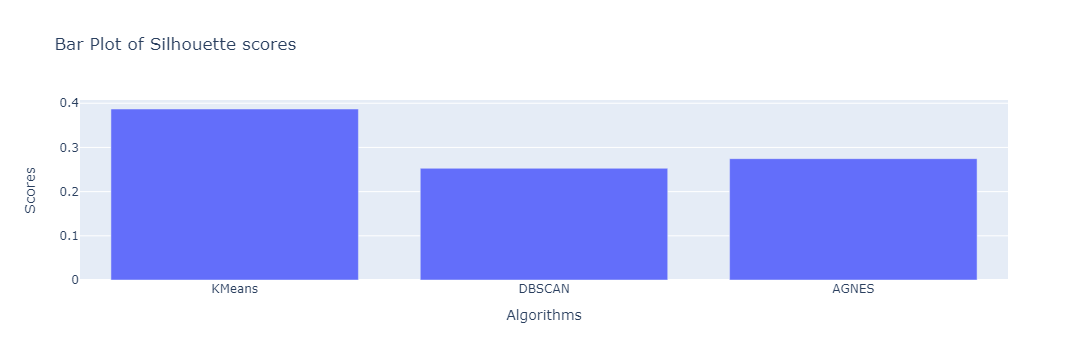

In [97]:
values = [kmeans_ss, dbscan_ss, agnes_ss]  
labels = ['KMeans', 'DBSCAN', 'AGNES'] 

# Creating bar plot
fig = go.Figure(data=[go.Bar(x=labels, y=values)])

# Adding title and axis labels
fig.update_layout(title='Bar Plot of Silhouette scores', xaxis_title='Algorithms', yaxis_title='Scores')

# Show plot
fig.show()

## Final Cluster Analysis

In [111]:
# Fixiing original dataframe for generating summary
df.update({'Work_Experience': new_df['Work_Experience']})
df['cluster'] = clusters_kmeans

In [113]:
df.head(5)

Gender Ever_Married  Age Graduated     Profession  Work_Experience  \
0    Male           No   22        No     Healthcare              1.0   
1  Female          Yes   38       Yes       Engineer              5.4   
2  Female          Yes   67       Yes       Engineer              1.0   
3    Male          Yes   67       Yes         Lawyer              0.0   
4  Female          Yes   40       Yes  Entertainment              3.8   

   Spending_Score  Family_Size  cluster  
0             0.0          4.0        8  
1             1.0          3.0        4  
2             0.0          1.0        3  
3             2.0          2.0        3  
4             2.0          6.0        4

In [114]:
# Group the data by the 'cluster' column
cluster_groups = df.groupby('cluster')

# Calculate summary statistics for each cluster
cluster_summary = cluster_groups.describe()

In [116]:
# Displaying all columns
pd.set_option('display.max_columns', None)

In [117]:
cluster_summary

Age                                                      \
          count       mean        std   min   25%   50%   75%   max   
cluster                                                               
0         972.0  52.053498   9.432683  45.0  48.0  50.0  52.0  89.0   
1        1188.0  39.183502   2.593167  35.0  37.0  39.0  41.0  43.0   
2         946.0  59.080338   3.789416  42.0  57.0  59.0  61.0  83.0   
3         617.0  68.982172   2.566266  65.0  67.0  69.0  71.0  76.0   
4        1020.0  38.954902   2.597637  35.0  37.0  39.0  41.0  46.0   
5        1419.0  29.085271   2.603389  25.0  27.0  29.0  31.0  33.0   
6         878.0  65.439636  15.947830  45.0  50.0  67.0  81.0  89.0   
7        1012.0  32.685771   7.181970  23.0  27.0  30.0  33.0  49.0   
8         624.0  20.480769   1.702500  18.0  19.0  20.0  22.0  23.0   

        Work_Experience                                                 \
                  count      mean       std  min  25%  50%   75%   max   
cluster                                                                  
0                 972.0  2.845885  3.300618  0.0  0.0  1.0  4.05  14.0   
1                1188.0  2.869024  3.371662  0.0  0.0  1.0  5.00  14.0   
2                 946.0  2.681184  3.247557  0.0  0.0  1.0  4.00  14.0   
3                 617.0  2.701783  3.233030  0.0  0.0  1.0  4.20  14.0   
4                1020.0  2.973333  3.341815  0.0  0.0  1.0  5.00  14.0   
5                1419.0  2.755603  3.355189  0.0  0.0  1.0  4.00  14.0   
6                 878.0  2.903189  3.428124  0.0  0.0  1.0  5.00  14.0   
7                1012.0  3.178261  3.515392  0.0  0.4  1.0  6.00  14.0   
8                 624.0  2.965705  3.428206  0.0  0.0  1.0  5.00  14.0   

        Spending_Score                                               \
                 count      mean       std  min  25%  50%  75%  max   
cluster                                                               
0                972.0  0.862140  0.771217  0.0  0.0  1.0  1.0  2.0   
1               1188.0  0.564815  0.689315  0.0  0.0  0.0  1.0  2.0   
2                946.0  0.853066  0.753529  0.0  0.0  1.0  1.0  2.0   
3                617.0  0.995138  0.874406  0.0  0.0  1.0  2.0  2.0   
4               1020.0  0.496078  0.684171  0.0  0.0  0.0  1.0  2.0   
5               1419.0  0.186751  0.487872  0.0  0.0  0.0  0.0  2.0   
6                878.0  0.781321  0.855603  0.0  0.0  1.0  2.0  2.0   
7               1012.0  0.310277  0.610308  0.0  0.0  0.0  0.0  2.0   
8                624.0  0.080128  0.371526  0.0  0.0  0.0  0.0  2.0   

        Family_Size                                               
              count      mean       std  min  25%  50%  75%  max  
cluster                                                           
0             972.0  3.090535  1.467124  1.0  2.0  3.0  4.0  9.0  
1            1188.0  2.765152  1.393654  1.0  2.0  2.0  4.0  9.0  
2             946.0  2.776956  1.474272  1.0  2.0  2.0  4.0  9.0  
3             617.0  2.312804  1.225162  1.0  2.0  2.0  3.0  9.0  
4            1020.0  2.350000  1.340122  1.0  1.0  2.0  3.0  9.0  
5            1419.0  3.384073  1.736053  1.0  2.0  3.0  4.0  9.0  
6             878.0  2.205011  1.220827  1.0  1.0  2.0  3.0  9.0  
7            1012.0  2.601779  1.582082  1.0  2.0  2.0  3.0  9.0  
8             624.0  4.017628  1.661965  1.0  3.0  4.0  5.0  9.0


Here's a story summary for each cluster based on the provided statistics:

### Cluster 0: The Mature Savers

Cluster 0 represents a group of individuals with an average age of approximately 52 years. They tend to have a moderate amount of work experience, with an average of around 2.85 years. In terms of spending habits, they exhibit a slightly conservative approach, with an average spending score of around 0.86. This group typically has a family size of around 3 members. Overall, Cluster 0 can be characterized as composed of mature individuals who prioritize saving and maintaining a stable financial situation.

### Cluster 1: The Middle-aged Moderates

Cluster 1 consists of individuals with an average age of about 39 years. They have a relatively low amount of work experience, averaging around 2.87 years. In terms of spending behavior, they display a conservative approach, with an average spending score of approximately 0.56. The family size for this cluster is typically around 2 members. Cluster 1 can be seen as comprising middle-aged individuals who adopt a moderate approach to spending and prioritize financial stability.

### Cluster 2: The Elderly Spenders

Cluster 2 represents an older demographic, with an average age of approximately 59 years. Despite their age, they still have a modest amount of work experience, averaging around 2.68 years. This group tends to have a slightly higher spending score compared to other clusters, with an average of around 0.85. The family size for this cluster is similar to others, averaging around 2 members. Cluster 2 can be characterized as comprising elderly individuals who are relatively comfortable with spending and maintaining financial independence.

### Cluster 3: The Senior Frugalists

Cluster 3 consists of individuals with an average age of about 69 years, making them the oldest cluster. They have a moderate amount of work experience, averaging around 2.70 years. Despite their age, they exhibit a conservative approach to spending, with an average spending score of approximately 1.0. The family size for this cluster is typically around 2 members. Cluster 3 can be seen as comprising senior citizens who prioritize frugality and financial security.

### Cluster 4: The Middle-aged Spenders

Cluster 4 consists of individuals with an average age of approximately 39 years, similar to Cluster 1. They have a slightly higher amount of work experience, averaging around 2.97 years. In terms of spending behavior, they exhibit a moderate approach, with an average spending score of approximately 0.50. The family size for this cluster is typically around 2 members. Cluster 4 can be characterized as comprising middle-aged individuals who strike a balance between spending and saving.

### Cluster 5: The Young Thrifts

Cluster 5 represents a younger demographic, with an average age of around 29 years. They have a moderate amount of work experience, averaging around 2.76 years. Despite their youth, they display a conservative approach to spending, with an average spending score of approximately 0.19. The family size for this cluster is similar to others, averaging around 2 members. Cluster 5 can be seen as comprising young individuals who prioritize saving and financial planning from an early age.

### Cluster 6: The Elderly Moderate Spenders

Cluster 6 consists of older individuals with an average age of approximately 65 years. They have a relatively high amount of work experience, averaging around 2.90 years. In terms of spending behavior, they adopt a moderate approach, with an average spending score of approximately 0.78. The family size for this cluster is typically around 2 members. Cluster 6 can be characterized as comprising elderly individuals who are comfortable with moderate spending and prioritize financial stability in their later years.

### Cluster 7: The Young Spenders

Cluster 7 represents a younger demographic, with an average age of about 33 years. They have a moderate amount of work experience, averaging around 3.18 years. This group tends to have a slightly higher spending score compared to other clusters, with an average of around 0.31. The family size for this cluster is similar to others, averaging around 2 members. Cluster 7 can be seen as comprising young individuals who are comfortable with spending and enjoy financial freedom in their youth.

### Cluster 8: The Young Savers

Cluster 8 consists of the youngest individuals, with an average age of approximately 20 years. They have a relatively low amount of work experience, averaging around 2.97 years. Despite their age, they exhibit a moderate approach to spending, with an average spending score of around 0.08. The family size for this cluster is typically around 4 members. Cluster 8 can be characterized as comprising young individuals who prioritize saving and financial planning from a young age.